In [1]:
import requests
from bs4 import BeautifulSoup
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# 進入台灣銀行牌告匯率網頁，查看當日匯率資料
url = "https://rate.bot.com.tw/xrt?Lang=zh-TW"
resp = requests.get(url)
resp.encoding = 'utf-8'
html = BeautifulSoup(resp.text, "lxml")

In [3]:
rateDict = {}
for curAttrs in html.find('table', attrs={'title':'牌告匯率'}).find(name='tbody').find_all(name='tr'):
    curName = curAttrs.find(name='div', attrs={'class':'visible-phone print_hide'}).text.strip()
    tDict = {}
    for p in curAttrs.find_all(name='td', attrs={'class':'text-right display_none_print_show print_width'}):
        tDict[p['data-table']] = p.text
    rateDict[curName] = tDict
pd.DataFrame(rateDict).T

,本行即期買入,本行即期賣出,本行現金買入,本行現金賣出
美金 (USD),30.09,30.19,29.74,30.41
港幣 (HKD),3.85,3.91,3.724,3.928
英鎊 (GBP),37.71,38.13,36.71,38.83
澳幣 (AUD),18.82,19.05,18.55,19.33
加拿大幣 (CAD),21.67,21.89,21.28,22.19
新加坡幣 (SGD),21.32,21.5,20.83,21.74
瑞士法郎 (CHF),31.74,32.03,31.08,32.28
日圓 (JPY),0.2826,0.2866,0.2753,0.2881
南非幣 (ZAR),1.805,1.885,-,-
瑞典幣 (SEK),3.06,3.16,2.72,3.24


In [4]:
url = 'https://rate.bot.com.tw/xrt/history/USD'
resp = requests.get(url)
resp.encoding = 'utf-8'
html = BeautifulSoup(resp.text, "lxml")
#get currency item
ciList = []
for item in html.find(name='main').find('select', attrs={'class':'input-medium'}).find_all('option'):
    ciList.append(item['value'])

In [5]:
inputDate = '2020-03'
mdf = pd.DataFrame()
for currency in ciList:
    htmlFormat = '/quote/{}/{}'.format(inputDate, currency)
    urlHead = 'https://rate.bot.com.tw/xrt'
    urlGo = urlHead+htmlFormat
    resp = requests.get(urlGo)
    resp.encoding = 'utf-8'
    html = BeautifulSoup(resp.text, "lxml")
    hisData = html.find('table', attrs={'class':'table table-striped table-bordered table-condensed table-hover'})\
              .find('tbody').find_all('tr')
    mDict = {}
    tDict = {}
    for i in hisData:
        dataList = i.text.strip().split('\n')
        tDict[dataList[0]] = {
                              '本行現金匯率買入':dataList[2], 
                              '本行現金匯率賣出':dataList[3],
                              '本行即期匯率買入':dataList[4],
                              '本行即期匯率賣出':dataList[5],
                             }
    mDict[currency] = tDict
    tdf = pd.DataFrame(mDict[currency]).T.reset_index().rename(columns={'index':'Date'})
    tdf.insert(tdf.columns.get_loc('Date'), 'Type', currency)
    mdf = pd.concat([mdf, tdf])
#轉日期
mdf['Date'] = pd.to_datetime(mdf['Date'])
#轉數字
for i in mdf.columns[2:]:
    mdf[i] = mdf[i].apply(lambda x: pd.to_numeric(x, errors='ignore'))
mdf.head()

,Type,Date,本行即期匯率買入,本行即期匯率賣出,本行現金匯率買入,本行現金匯率賣出
0,USD,2020-03-13,30.09,30.19,29.74,30.41
1,USD,2020-03-12,30.03,30.13,29.68,30.35
2,USD,2020-03-11,30.01,30.11,29.66,30.33
3,USD,2020-03-10,29.94,30.04,29.59,30.26
4,USD,2020-03-09,30.03,30.13,29.68,30.35


C:\Users\peter\Anaconda3\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


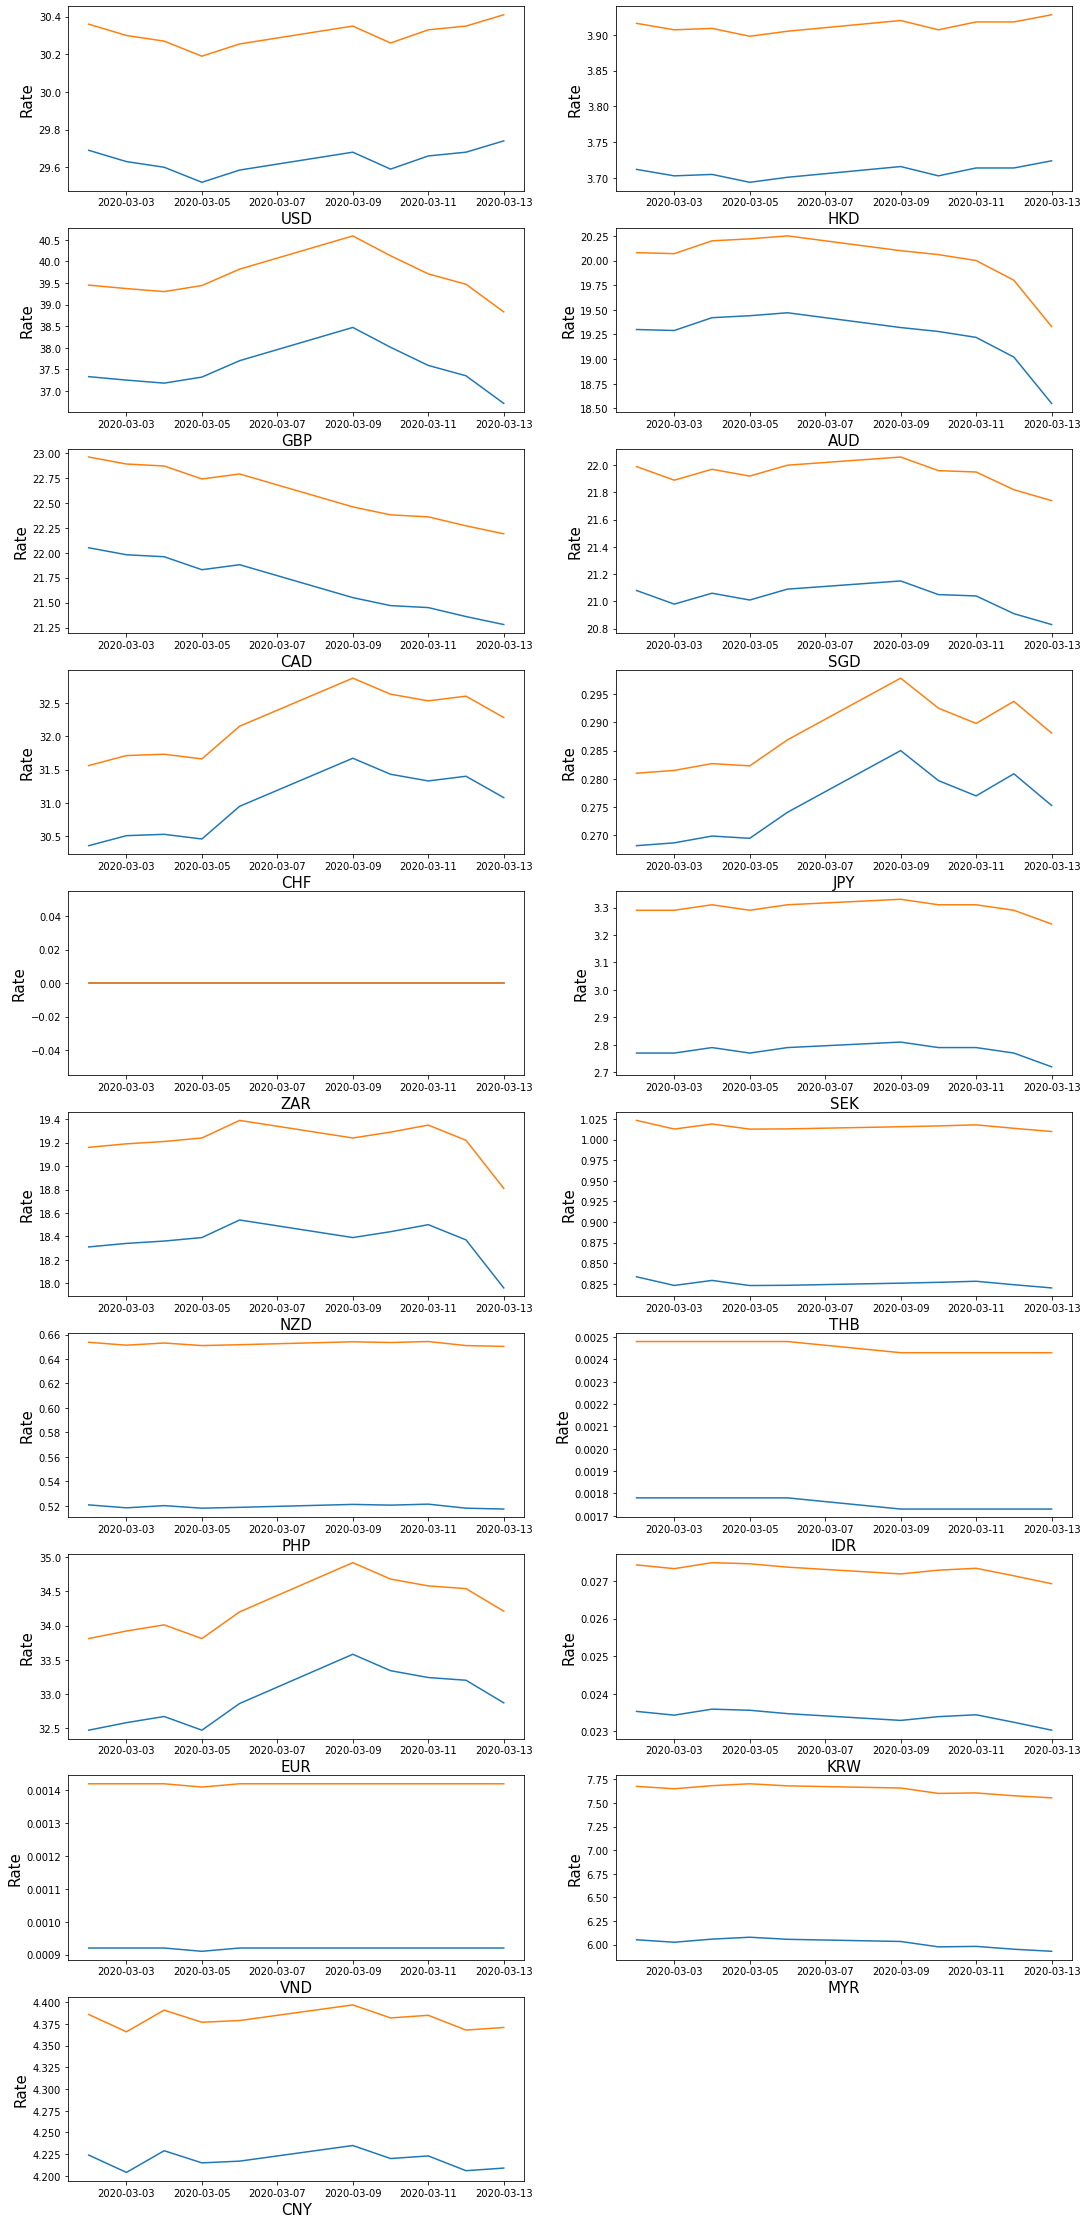

In [6]:
plt.figure(figsize = (18, 40))
for i, v in enumerate(mdf['Type'].unique()):
    tdf = mdf[mdf['Type']==v].set_index('Date').copy()
    plt.subplot(10,2,i+1)
    plt.plot(tdf[['本行現金匯率買入','本行現金匯率賣出']])
    plt.xlabel(v, fontsize = 15)
    plt.ylabel('Rate', fontsize = 15)